# COMP 352 Final Project
# A Data Driven Analysis of Optimal Blackjack Strategies

**Authors:** Joe Cox, Augusto Escudero, Hreinson Vanover

**Date:** 12/15/2024

**Dataset:** https://www.kaggle.com/datasets/dennisho/blackjack-hands/data

## Table of Contents:
* [Data Importing and Pre-processing](#data-importing)
* [Data Analysis and Visualization](#data-vis)
* [Data Analytics](#data-analytics)

## Data Importing and Pre-processing <a class="anchor" id="data-importing"></a>

In [302]:
# Import Necessary Libraries

# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Machine Learning Models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Visualization Tools
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay


In [303]:
# Read in csv file
# Using local file instead of uploading to repository
# Size is 3.63GB

# Import dataset into Pandas DataFrame
entire_blackjack_df = pd.read_csv("blackjack_simulator.csv", nrows=1000000)


In [304]:
# Describing characteristics

blackjack_df = entire_blackjack_df

print("Dataset shape (rows, columns): ", blackjack_df.shape)

numerical_columns = blackjack_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = blackjack_df.select_dtypes(include=['object', 'category']).columns

print('\nColumn types:')
print('---'*3)
print('Number of numerical variables: ', len(numerical_columns))
print('Number of categorical variables: ', len(categorical_columns))
print('---'*3)

print("\nData types: ")
print("---"*3)
print(blackjack_df.dtypes)

Dataset shape (rows, columns):  (1000000, 12)

Column types:
---------
Number of numerical variables:  6
Number of categorical variables:  6
---------

Data types: 
---------
shoe_id                 int64
cards_remaining         int64
dealer_up               int64
initial_hand           object
dealer_final           object
dealer_final_value     object
player_final           object
player_final_value     object
actions_taken          object
run_count               int64
true_count              int64
win                   float64
dtype: object


In [305]:
# Check column names
blackjack_df.columns

Index(['shoe_id', 'cards_remaining', 'dealer_up', 'initial_hand',
       'dealer_final', 'dealer_final_value', 'player_final',
       'player_final_value', 'actions_taken', 'run_count', 'true_count',
       'win'],
      dtype='object')

In [306]:
blackjack_df.head()

,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,true_count,win
0,0,416,10,"[10, 11]","[10, 4, 10]",24,"[[10, 11]]",['BJ'],[['S']],1,0,1.5
1,0,411,10,"[5, 5]","[10, 8]",18,"[[5, 5, 11]]",[21],"[['H', 'S']]",-2,0,1.0
2,0,406,6,"[3, 10]","[6, 6, 10]",22,"[[3, 10]]",[13],[['S']],-2,0,1.0
3,0,401,10,"[5, 9]","[10, 8]",18,"[[5, 9, 11, 3]]",[18],"[['H', 'H', 'S']]",-1,0,0.0
4,0,395,8,"[6, 10]","[8, 2, 10]",20,"[[6, 10, 10]]",[26],[['H']],-1,0,-1.0


### Handling missing data

In [307]:
total = blackjack_df.isnull().sum().sort_values(ascending=False)
percent = (blackjack_df.isnull().sum() / blackjack_df.isnull().count()).sort_values(
    ascending=False
)

missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(20)

,Total,Percent
shoe_id,0,0.0
cards_remaining,0,0.0
dealer_up,0,0.0
initial_hand,0,0.0
dealer_final,0,0.0
dealer_final_value,0,0.0
player_final,0,0.0
player_final_value,0,0.0
actions_taken,0,0.0
run_count,0,0.0


Note that there is no missing data

### Transform the Data

#### Label encode categorical variables

In [308]:
# Create a mapping dictionary
# S = Stand , H = Hit , D = Double , P = Split , R = Surrender , I = Insurance , N = No Insurance, ] = No move(dealer had BJ)
mapping = {'S': 0, 'H': 1, 'D': 2, 'P': 3, 'R': 4, 'I': 5, 'N': 6, ']': 7}

# Apply mapping to the column
blackjack_df['first_move'] = blackjack_df['actions_taken'].str[3].map(mapping)

check_df = blackjack_df[["actions_taken", "first_move"]]
print(check_df.head)

<bound method NDFrame.head of             actions_taken  first_move
0                 [['S']]           0
1            [['H', 'S']]           1
2                 [['S']]           0
3       [['H', 'H', 'S']]           1
4                 [['H']]           1
...                   ...         ...
999995  [['H', 'H', 'S']]           1
999996            [['S']]           0
999997       [['H', 'S']]           1
999998            [['S']]           0
999999  [['H', 'H', 'S']]           1

[1000000 rows x 2 columns]>


#### Perform Feature Construction

In [309]:
items = blackjack_df['initial_hand']
item = items[0]
print(items)

print(type(item))

blackjack_df[['left_number', 'right_number']] = blackjack_df['initial_hand'].str.strip('[]').str.split(', ', expand=True).astype(int)

0         [10, 11]
1           [5, 5]
2          [3, 10]
3           [5, 9]
4          [6, 10]
            ...   
999995      [3, 2]
999996     [7, 10]
999997      [3, 2]
999998     [9, 10]
999999     [11, 4]
Name: initial_hand, Length: 1000000, dtype: object
<class 'str'>


In [310]:
# Define conditions and choices
conditions = [
    blackjack_df['win'] > 0,
    blackjack_df['win'] == 0,
    blackjack_df['win'] < 0,
]
choices = [2, 1, 0]

# Apply the conditions to create a new column
blackjack_df['win_encoded'] = np.select(conditions, choices)

In [311]:
blackjack_df['player_hand_total'] = blackjack_df['left_number'] + blackjack_df['right_number']

In [312]:
# drop duplicate rows
print(blackjack_df.shape)
blackjack_df = blackjack_df.drop_duplicates()
print(blackjack_df.shape)
# there is none

(1000000, 17)
(1000000, 17)


In [313]:
# remove unnecessary columns
filtered_blackjack_df = blackjack_df.drop(columns=["shoe_id", "cards_remaining", "dealer_final", "dealer_final_value", "player_final", "player_final_value", "actions_taken", "run_count", "true_count", 'initial_hand'])

na_columns_count = filtered_blackjack_df.isnull().any().sum()
print(na_columns_count)

rows_with_na = filtered_blackjack_df[filtered_blackjack_df.isnull().any(axis=1)]
print(rows_with_na)

0
Empty DataFrame
Columns: [dealer_up, win, first_move, left_number, right_number, win_encoded, player_hand_total]
Index: []


## Data Analysis and Visualization <a class="anchor" id="data-vis"></a>

--- Statistics for dealer_up ---
Mean: 7.3014
Median: 8.0000
Standard Deviation: 2.9196
Min: 2, Max: 11




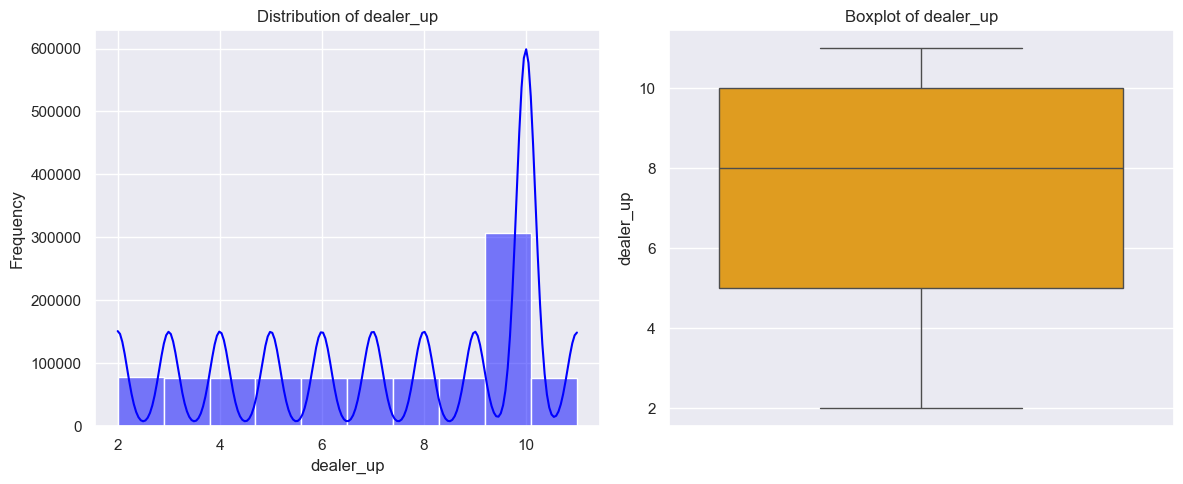

--- Statistics for win ---
Mean: -0.0057
Median: 0.0000
Standard Deviation: 1.1458
Min: -7.0, Max: 7.0




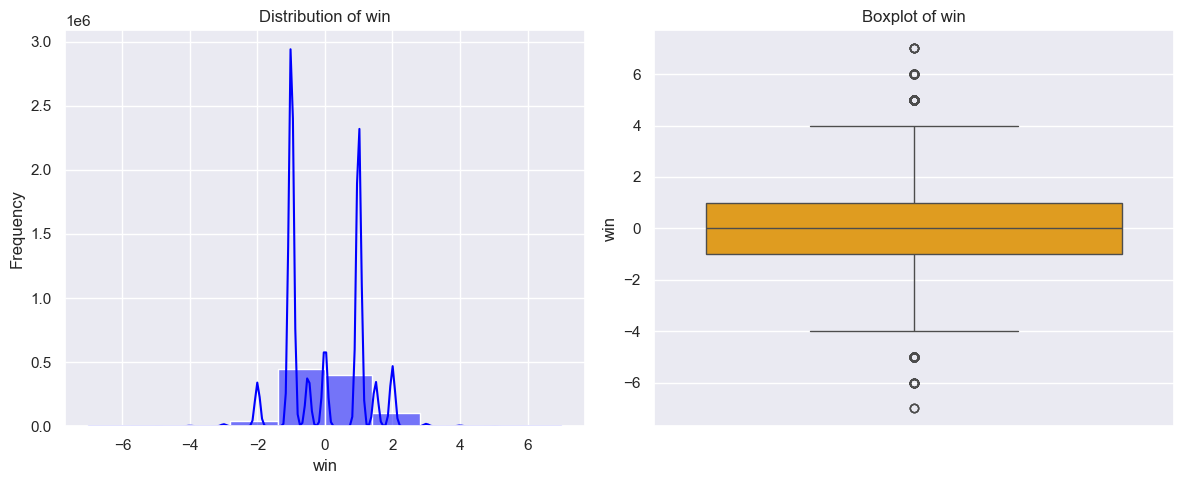

--- Statistics for first_move ---
Mean: 1.3767
Median: 1.0000
Standard Deviation: 1.8994
Min: 0, Max: 7




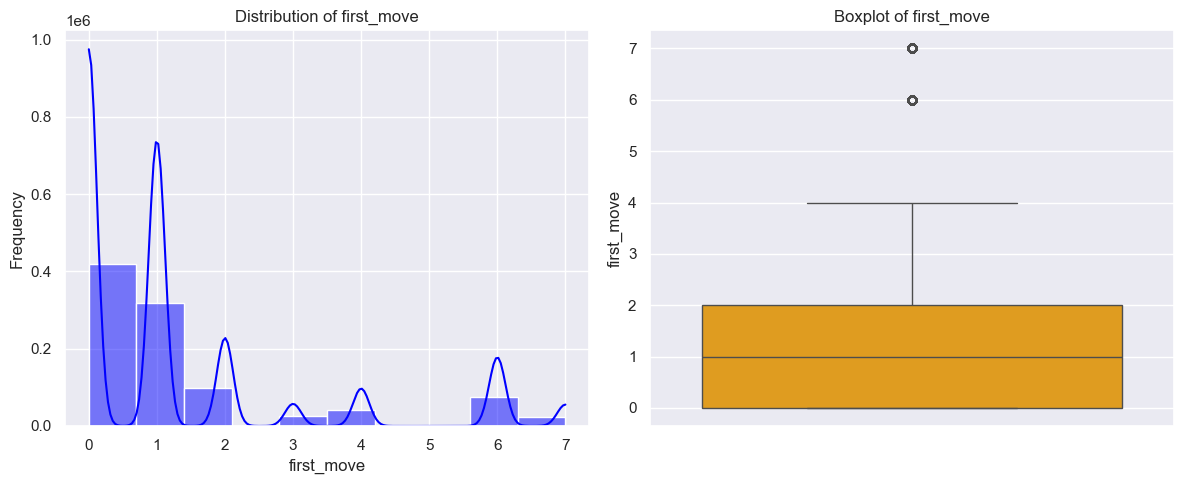

--- Statistics for left_number ---
Mean: 7.3064
Median: 8.0000
Standard Deviation: 2.9196
Min: 2, Max: 11




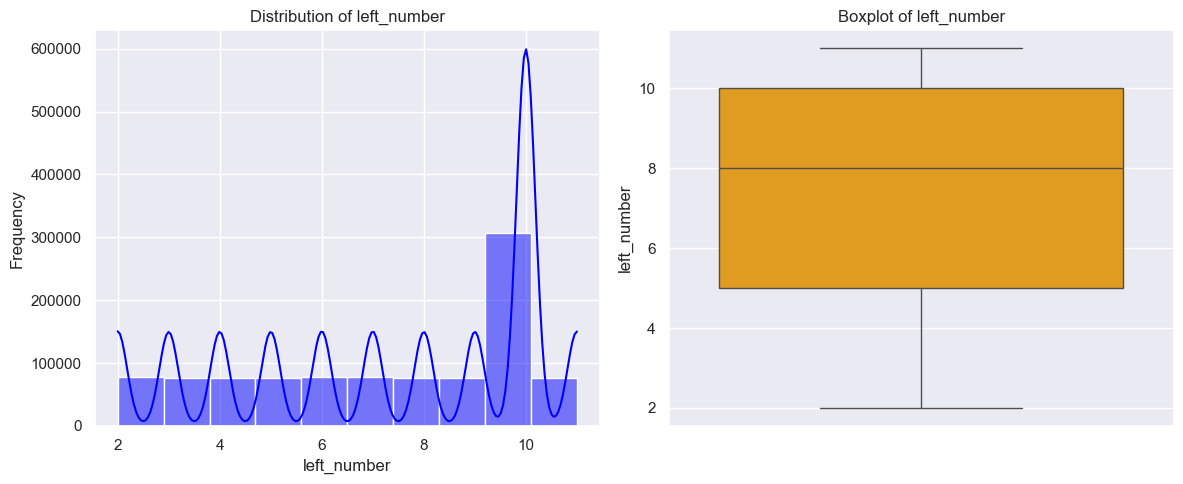

--- Statistics for right_number ---
Mean: 7.3103
Median: 8.0000
Standard Deviation: 2.9201
Min: 2, Max: 11




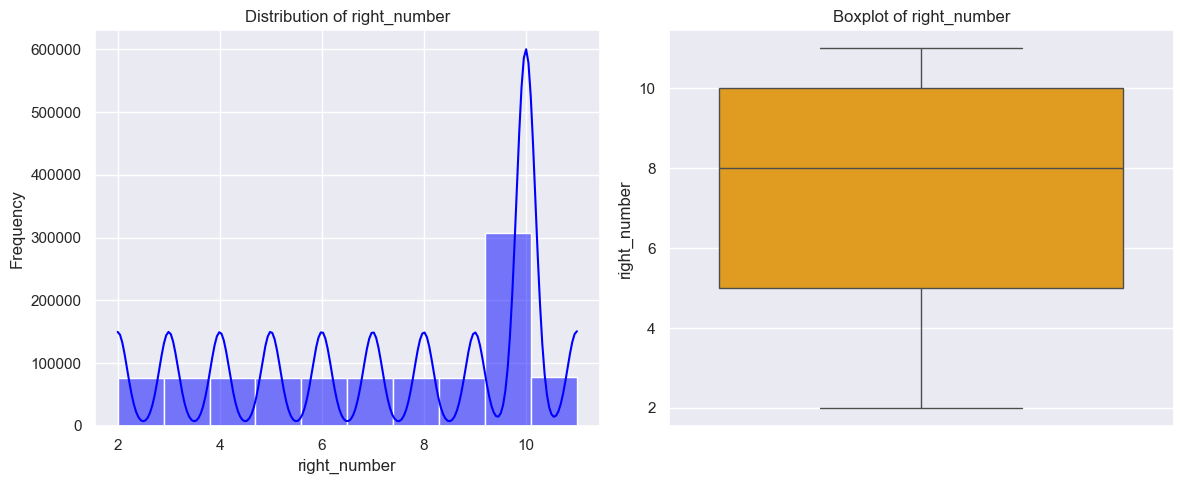

--- Statistics for win_encoded ---
Mean: 0.9272
Median: 1.0000
Standard Deviation: 0.9544
Min: 0, Max: 2




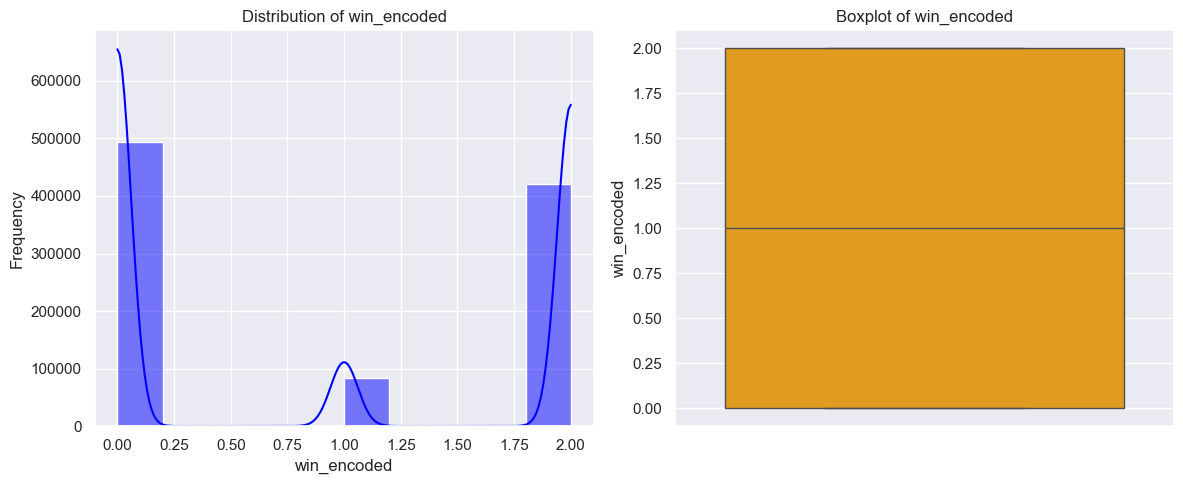

--- Statistics for player_hand_total ---
Mean: 14.6167
Median: 15.0000
Standard Deviation: 4.1238
Min: 4, Max: 22




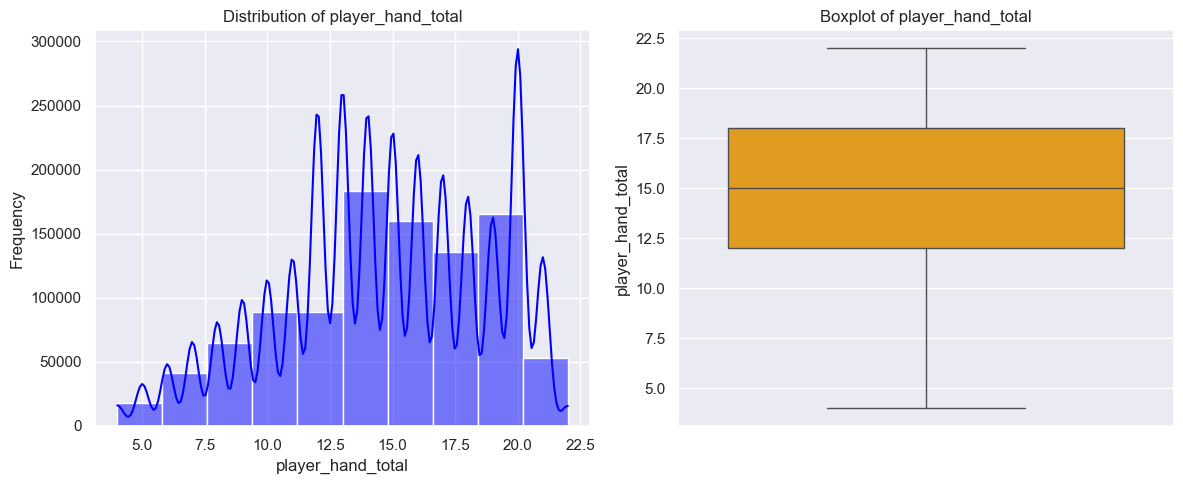

In [314]:
# Function to calculate measures of centrality and distribution
def display_statistics_and_visuals(df, column):
    print(f"--- Statistics for {column} ---")
    print(f"Mean: {df[column].mean():.4f}")
    print(f"Median: {df[column].median():.4f}")
    print(f"Standard Deviation: {df[column].std():.4f}")
    print(f"Min: {df[column].min()}, Max: {df[column].max()}")
    print("\n")
    
    # Plot Histogram and KDE
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=False, bins=10, discrete=True, color='blue')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    
    # Plot Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[column], color='orange')
    plt.title(f"Boxplot of {column}")
    plt.ylabel(column)
    
    plt.tight_layout()
    plt.show()

# Analyze columns
columns_to_analyze = ['dealer_up', 'win', 'first_move', 'left_number', 'right_number', 'win_encoded', 'player_hand_total']

for col in columns_to_analyze:
    display_statistics_and_visuals(filtered_blackjack_df, col)


#### Distribution of Individual Variables

- **dealer_up**, **left_number**, **right_number**: They are distributed in the exact same way because they represent card values that range from 1 - 11, with 10 being the most common value because from the deck of cards the queen, the jack, and the king are all worth 10, aside from the 10 card.
- **win**: spread from negative to positive values, and we can see that the most common values are -1 and 1, which means that in most cases, players lose or win their initial bets.
- **first_move**: we can see that 0 is the most common value, which is our encoding for 'STAND', which makes sense in the context of blackjack.
- **player_hand_total**: shows a distribution that peaks around 14-16, which is tuypical in blackjack since we have two random cards where the max value for a single card is 10.


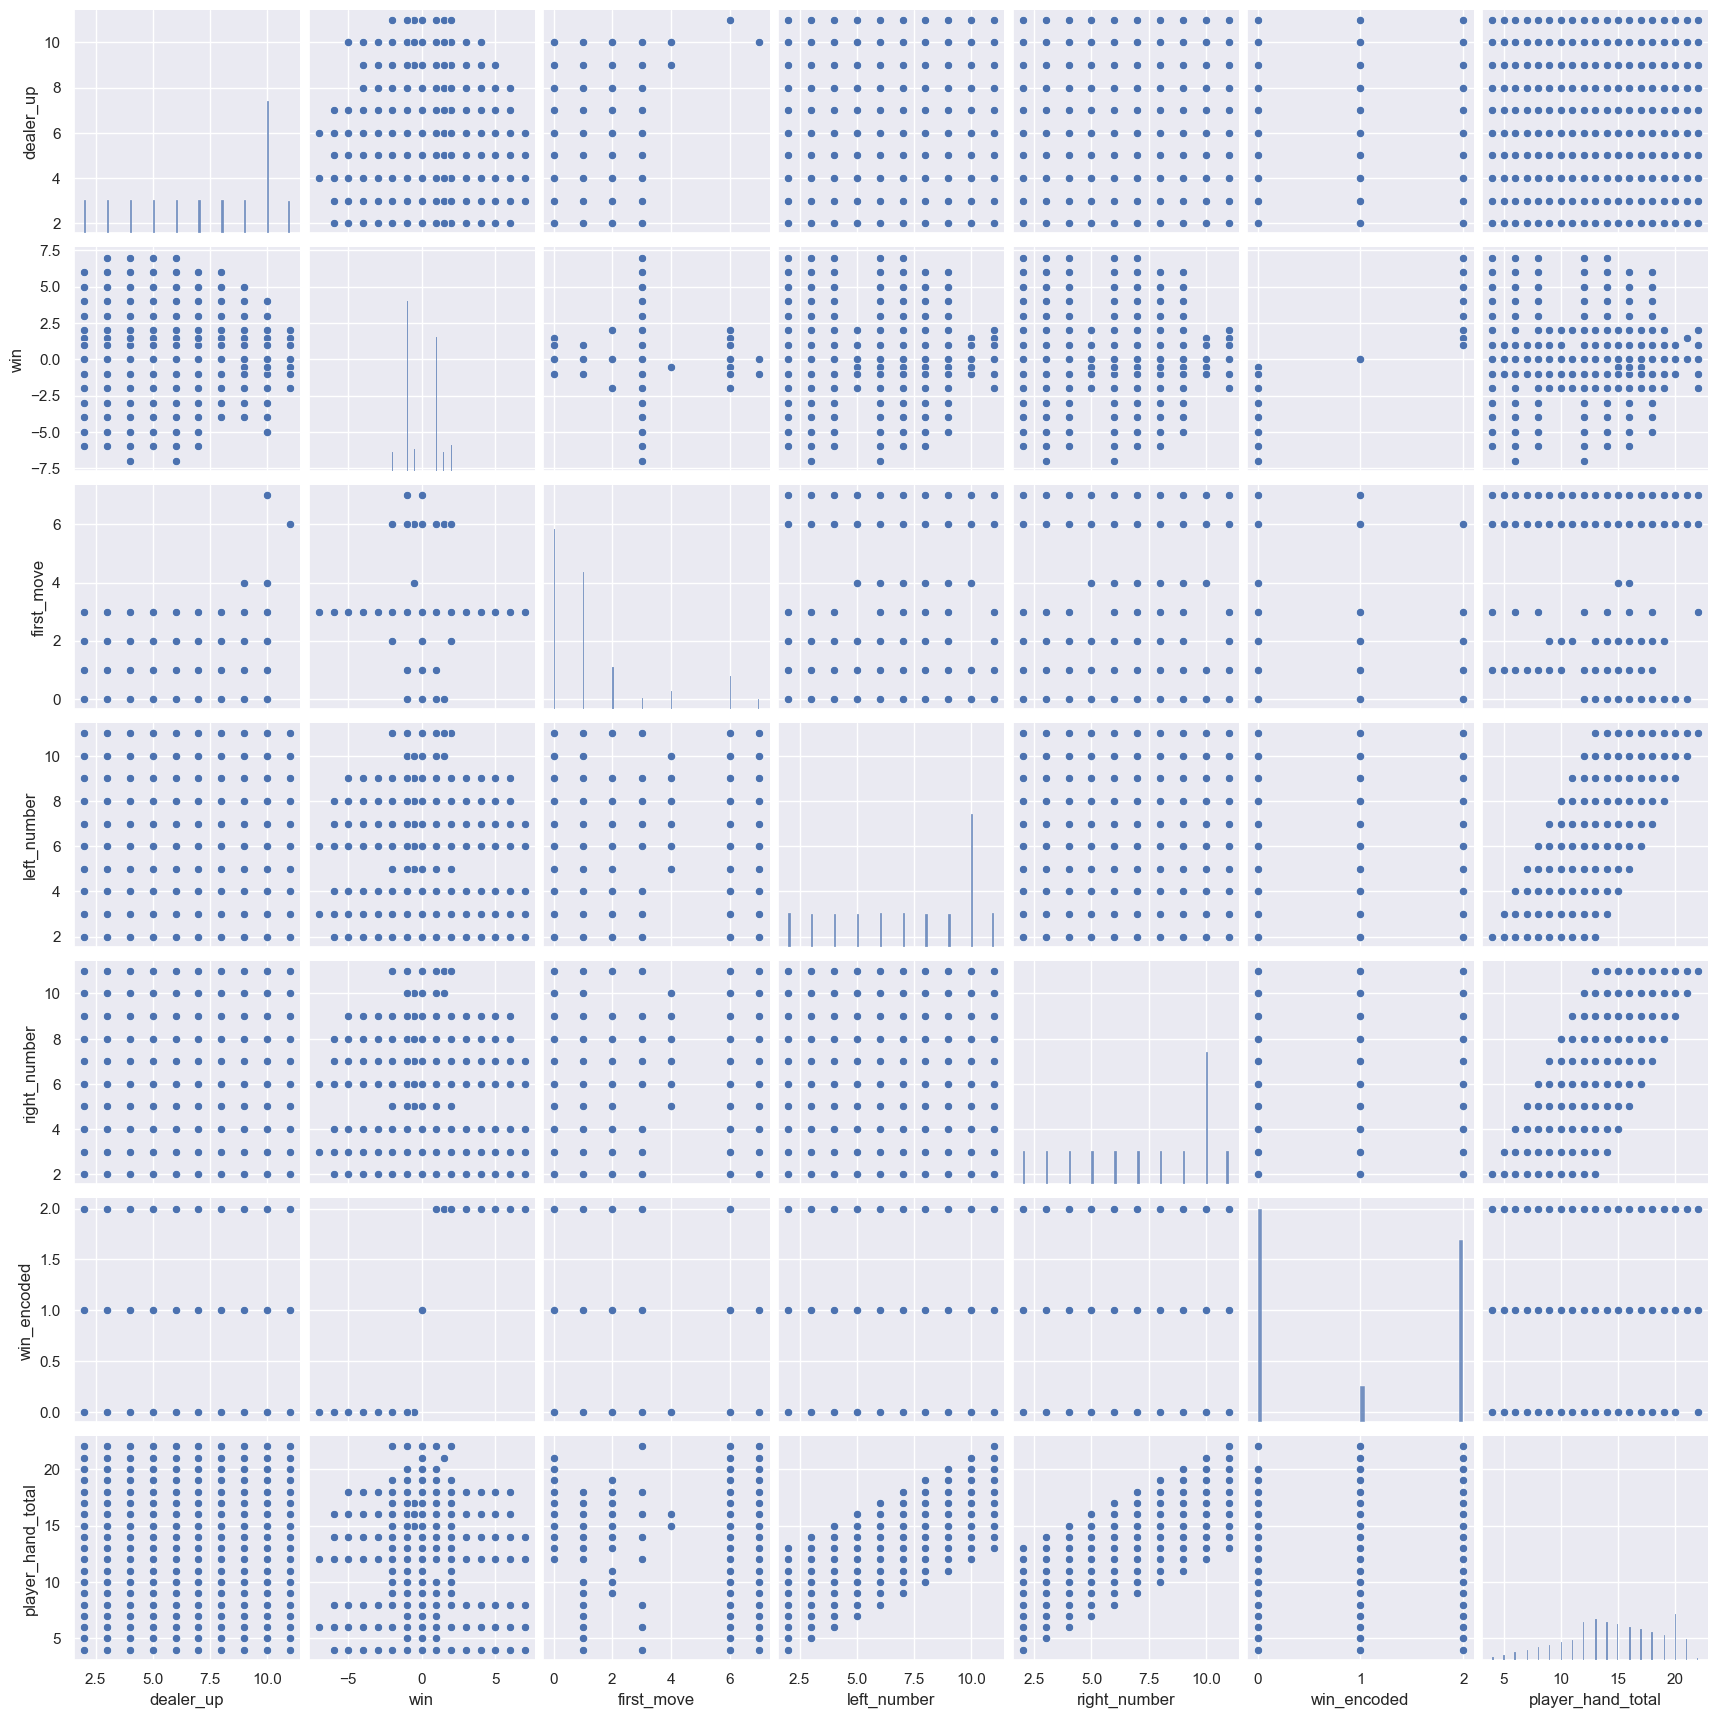

In [315]:
# scatterplot
sns.set()
cols = [
    "dealer_up",
    "win",
    "first_move",
    "left_number",
    "right_number",
    "win_encoded",
    "player_hand_total"
]
sns.pairplot(filtered_blackjack_df[cols], height=2.5)
plt.show()

#### Relationships between variables

- **player_hand_total** vs. **left_number/right_number**: We can see a very strong correlation, which is because **player_hand_total** was constructed from the sum of the other two variables.
- **first_move** vs. **player_hand_total**: We might notice that certain initial lodas might lead to players choosing specific moves, for example low totals might encourage hits, and high totals might encourage stands.
- **dealer_up** vs. **left_number/right_number**: They're uniformly distributed because there's no strong correlation, just a scattered spread since they're both random draws.
- **dealer_up** vs. **first_move**: There seems to be some correlation likely due to the outliers.

Correlation Matrix

<Axes: >

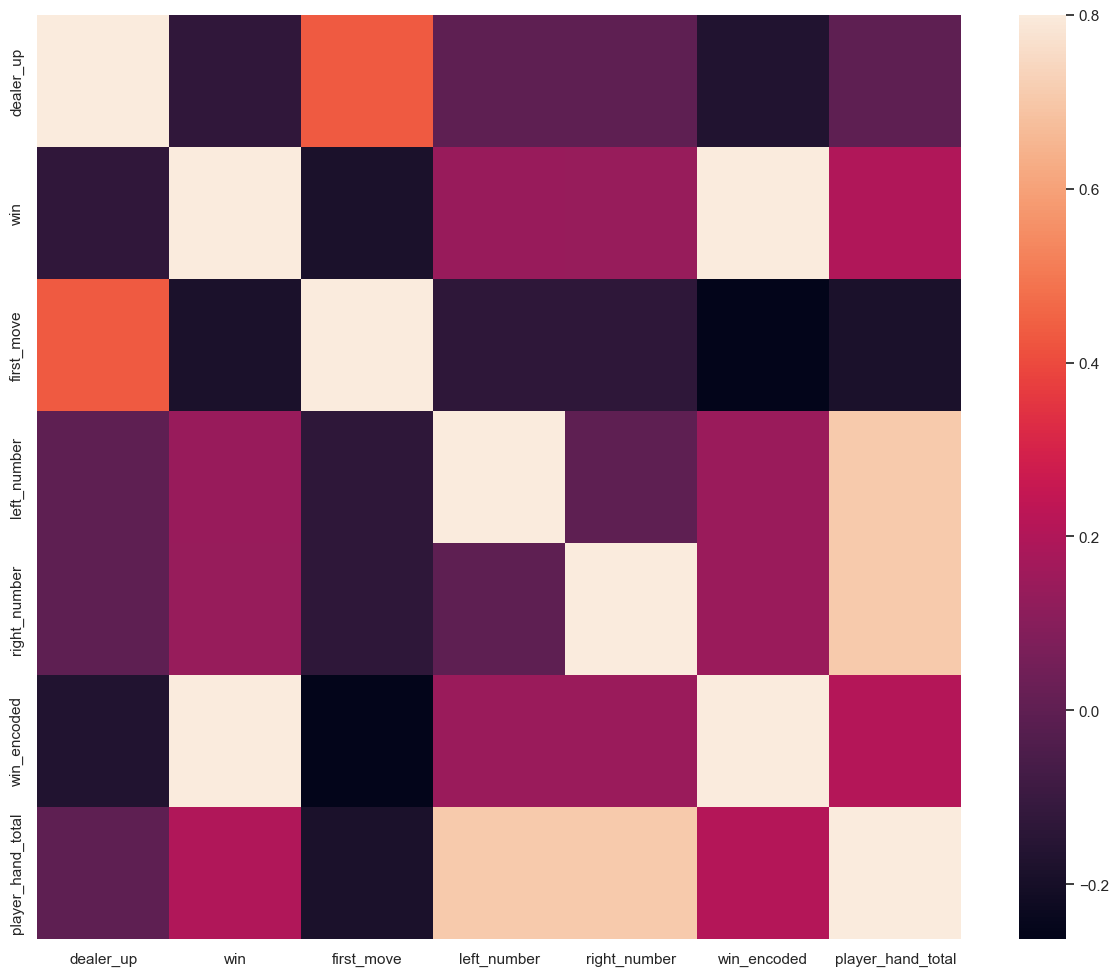

In [316]:
corrmat = filtered_blackjack_df.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=0.8, square=True)


#### Relationships between variables

- **left_number** and **right_number** have a positive, though weak, correlation, and this is likely because even though they're both random draws, they come from the same deck.
- **dealer_up** vs. **first_move**: We can see that there is a noticeable relationship between the dealer's up card and the player's first decision, compared to the relationships between the other variables.
- **player_hand_total** or (**left_number** and **right_number**) vs. **win_encoded**: We can also see that there is a noticeable correlation here, however not as strong as **dealer_up** vs. **first_move**, which makes sense in the context of blackjack.

## Data Analytics <a class="anchor" id="data-analytics"></a>

Below are 3 algorithms we used for predicting win/push/loss in Blackjack:
- Logistic Regression
- Decision Tree
- Gradient Boost

**Multinomial Logistic Regression:**
- This is a multi-calss classification algorithm
    - Useful because we are evaluating win, loss, and push
- It generalizes binary logistic regression by using a softmax function to output the probabilities for win, loss, and push.
- This algorithm aims to minimize the Maximum Likelihood Estimation
- Useful Classification Evaluation Metrics:
    - Logloss
    - ROC-AUC
    - Accuracy

**Decision Tree:**
- A classification and Regression Algorithm
- This algorithm is able to identify non-linear relationship
- This algorithm works by minimizing entropy in each node
    - Basically minimizing how much a system is disorganized and random
- A drawback of this algorithm is that it tends to overfit to the training data

**Gradient Boosting:**
- Also called Gradient Boosted Trees, or Boosted Regression Trees
- This algorithm is useful for classification and regression
- With this algorithm the Decision Trees are built sequentially
    - Each resulting tree is used to build the upcoming tree, which minimize the error.
    - This aims at minimizing the loss functin (gradient descent) sequentially
    - This process is called boosting
- This tends to be the best preforming algorithm with structured data
- We used xgboost library to implement this algorithm

#### Multinomial Logistic Regression

In [317]:
# Features and target
X = filtered_blackjack_df[['dealer_up', 'first_move', 'left_number', 'right_number', 'player_hand_total']]
y = filtered_blackjack_df['win_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multinomial Logistic Regression
logreg = LogisticRegression(class_weight='balanced', solver='lbfgs')
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

Accuracy: 0.4429

Confusion Matrix:
[[46098 25007 27678]
 [ 5719  7100  4003]
 [25074 23940 35381]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.47      0.52     98783
           1       0.13      0.42      0.19     16822
           2       0.53      0.42      0.47     84395

    accuracy                           0.44    200000
   macro avg       0.42      0.44      0.40    200000
weighted avg       0.53      0.44      0.47    200000



##### Logistic Regression Results on a 5 Fold Cross Validation

- Cross validation is technique that uses resampling to assess a models prefromance.
- It iteratively trains and tests on 5 different subsets of the data.
- This helps to identify the level of overfitting/underfitting of a model, providing us with a more accurate preformance estimate of the model.
- We used it to identify the mean model accuracy from the 5 iterations
- It is useful in our situation because Blackjack is random in nature

Why we chose Stratified K-Fold Cross Validation:
    Classification problems(predicting win_encoded with 0(loss), 1(push), 2(win)) can be imbalanced. Therefore, Stratified K-Fold Cross Validation ensures that each fold has the same class distribution as the original dataset. This helps prevent folds from being heavily skewed toward one class, which would result in biased training. In general, cross validation is a more robust way to evaluate a models preformance  compared to a single train-test split. This process allows us to reduce the risk of overfitting to a specific train-test split.

Why not Random Sampling Cross Validation?:

This method can create folds with class imbalance, which will lead to a biased preformance metric.

In [318]:
# Perform 5-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(logreg, X, y, cv=cv, scoring='accuracy')

# Output Results
print(f"Cross Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")

Cross Validation Scores: [0.44244  0.44358  0.44312  0.443965 0.44229 ]
Mean Accuracy: 0.4431
Standard Deviation: 0.0006


##### Logistic Regression Heatmap and Feature Importance Bar Plot

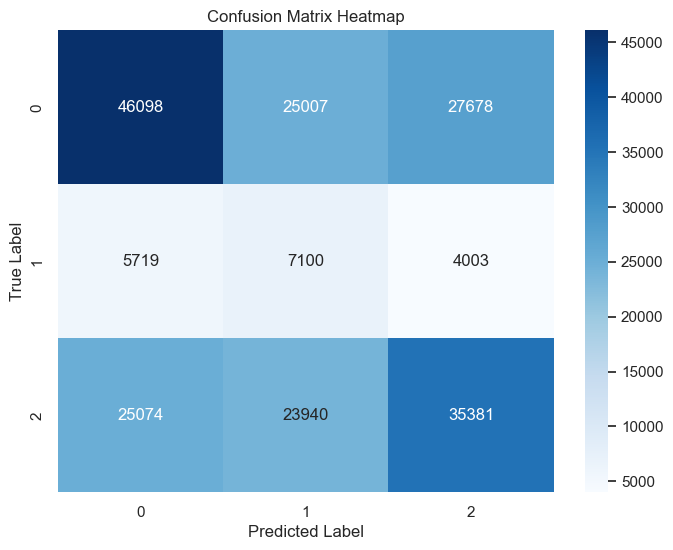

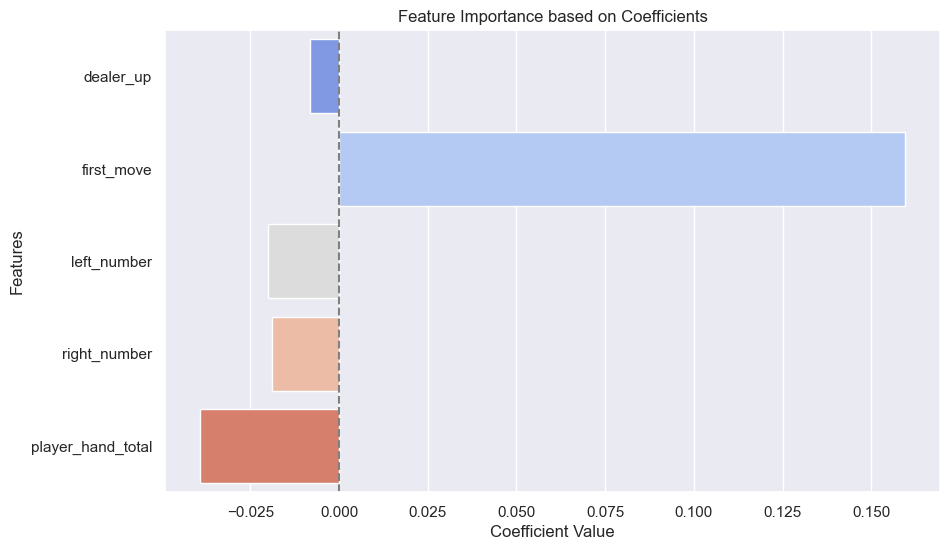

In [319]:
# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Feature Importance (Coefficient Values)
coefficients = logreg.coef_[0]
features = X.columns

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients, y=features, hue=features, palette="coolwarm")
plt.title("Feature Importance based on Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.axvline(0, color='gray', linestyle='--')
plt.show()


#### Decision Tree

Decision Tree vs. Logistic Regression:

We initially selected logistic regression for its simplicity and interpretability in problems. However, we decided to introduce the Decision Tree model because the preformance of the logistic regression model was poor. This algorithm is good for non-linear relationships and can handle interactions between multiple features. Furthermore, we believed the its tree visualization would help provide us with insight into the decision-making rules of Blackjack.

Accuracy: 0.6390

Confusion Matrix:
[[84329     0 14854]
 [ 9108     0  7723]
 [40524     0 43462]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.85      0.72     99183
           1       0.00      0.00      0.00     16831
           2       0.66      0.52      0.58     83986

    accuracy                           0.64    200000
   macro avg       0.43      0.46      0.43    200000
weighted avg       0.59      0.64      0.60    200000



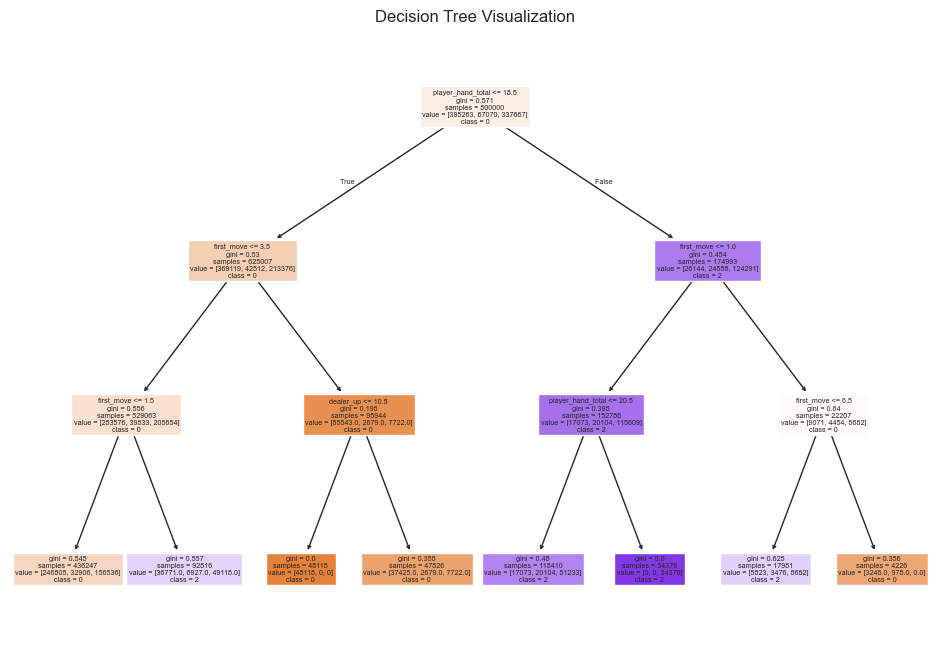

In [320]:
# Step 1: Define Features and Target
X = filtered_blackjack_df[['dealer_up', 'first_move', 'left_number', 'right_number', 'player_hand_total']]
y = filtered_blackjack_df['win_encoded']

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Step 3: Initialize and Train Decision Tree Model
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=3)
dt_model.fit(X_train, y_train)

# Step 4: Make Predictions
y_pred = dt_model.predict(X_test)

# Step 5: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

# Step 6: Visualize the Decision Tree
plt.figure(figsize=(12, 8))
tree.plot_tree(dt_model, feature_names=X.columns, class_names=['0', '1', '2'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()


##### Decision Tree Results on a 5 Fold Cross Validation

In [321]:
# Perform 5-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(dt_model, X, y, cv=cv, scoring='accuracy')

# Output Results
print(f"Cross Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")

Cross Validation Scores: [0.638325 0.636165 0.63684  0.63679  0.63586 ]
Mean Accuracy: 0.6368
Standard Deviation: 0.0009


##### Decision Heatmap and Feature Importance Bar Plot

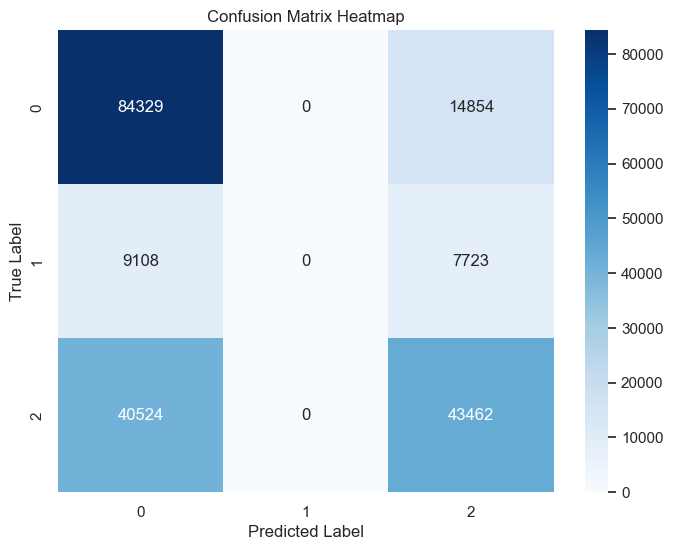

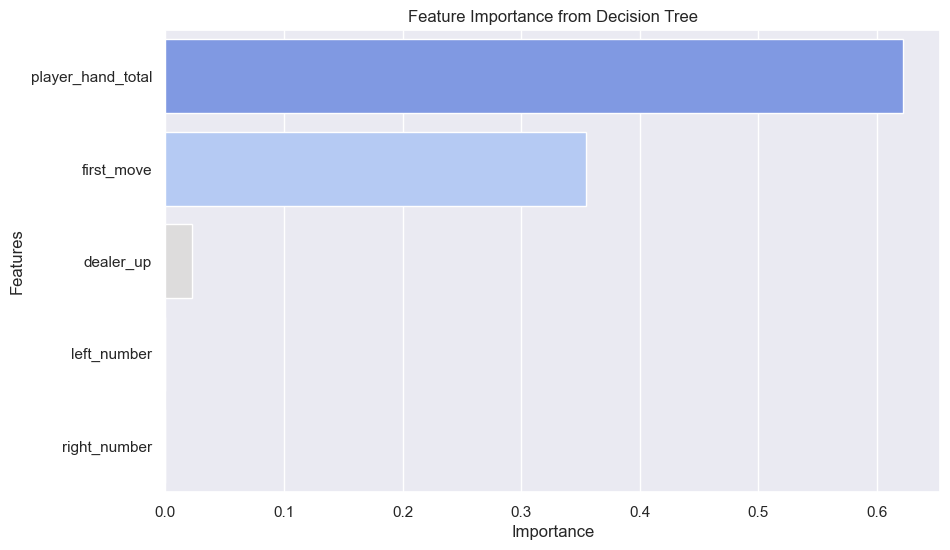

In [322]:
# Step 1: Plot Confusion Matrix as Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Step 2: Feature Importance Visualization
# Extract feature importances from the Decision Tree
feature_importances = dt_model.feature_importances_
features = X.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue=features, palette="coolwarm", legend=False)
plt.title("Feature Importance from Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


#### Gradient Boosting

After using a Decision Tree model, we used a gradient boosting model to see if we could improve our results further. This type of algorithm builds multiple shallow trees sequentially. Each following tree corrects the errors of its predecessor. This process reduces the bias and variance of the model in a controlled manner. Additionally, this algorithm is considered the best for structured data.

In [323]:
# Step 1: Define Features and Target
X = filtered_blackjack_df[['dealer_up', 'first_move', 'left_number', 'right_number', 'player_hand_total']]
y = filtered_blackjack_df['win_encoded']

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Step 3: Initialize and Train XGBoost Classifier
xgb_model = XGBClassifier(objective='multi:softmax', num_class=3)
xgb_model.fit(X_train, y_train)

# Step 4: Make Predictions
y_pred = xgb_model.predict(X_test)

# Step 5: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

Accuracy: 0.6459

Confusion Matrix:
[[79880     0 18922]
 [ 7466   209  9134]
 [35289     0 49100]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.81      0.72     98802
           1       1.00      0.01      0.02     16809
           2       0.64      0.58      0.61     84389

    accuracy                           0.65    200000
   macro avg       0.76      0.47      0.45    200000
weighted avg       0.67      0.65      0.61    200000



##### Gradient Boosting Results on a 5 Fold Cross Validation

In [324]:
# Perform 5-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='accuracy')

# Output Results
print(f"Cross Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")

Cross Validation Scores: [0.64812  0.646565 0.647095 0.6467   0.645735]
Mean Accuracy: 0.6468
Standard Deviation: 0.0008


#### Hyperparameter Tuning our Gradient Boosted Model

We used GridSearchCV, which is a Grid Search that systematically tests all possible combinations of hyperparameters within the grid. This allows us to see the best combination and create a better model. When combined with stratified K-Fold Cross Validation, Grid Search provides an unbiased estimate of the best parameters to use, all while maintaining class balance folds. The drawback of this method is that it can be computationally expensive.

In [325]:
param_grid = {
    'max_depth': [1, 2, 3],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
                           param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Retrain with best parameters
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Evaluate
print("Improved Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Improved Accuracy: 0.64643


##### Gradient Boosting Results with Hyperparameter Tuning on a 5 Fold Cross Validation

In [326]:
# Perform 5-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_xgb, X, y, cv=cv, scoring='accuracy')

# Output Results
print(f"Cross Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")

Cross Validation Scores: [0.648235 0.64699  0.64696  0.64701  0.64558 ]
Mean Accuracy: 0.6470
Standard Deviation: 0.0008


##### Gradient Boosting Heatmap and Feature Importance Bar Plot

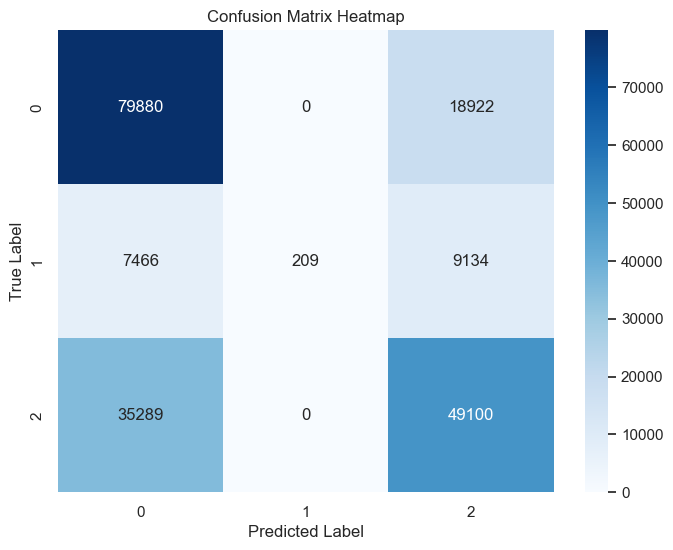

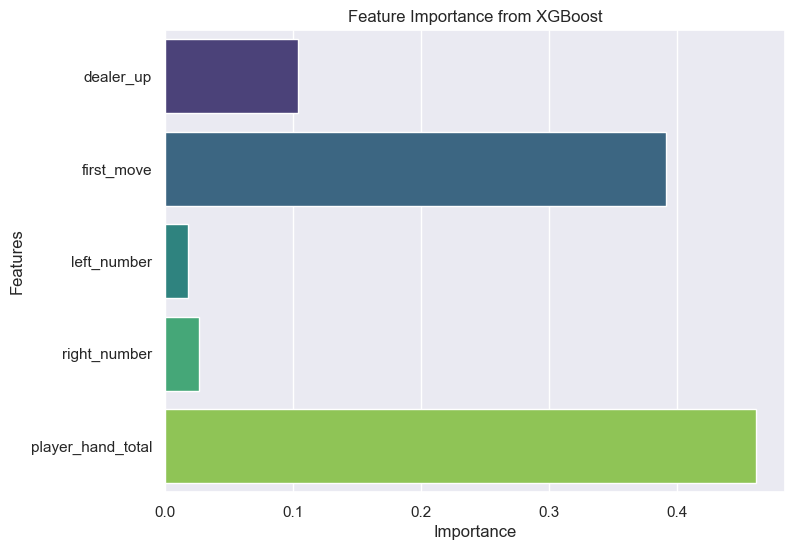

In [327]:
# Visualization 2: Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_xgb.classes_, yticklabels=best_xgb.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Visualization 3: Feature Importance
feature_importances = best_xgb.feature_importances_

plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances, y=X.columns, hue=X.columns, palette="viridis")
plt.title("Feature Importance from XGBoost")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


##### Second Gradient Boosted Model (Trained without player_hand_total)

A tree based model is useful to isolate subtle interations between features. In this case, it can learn the relationship between left and right cards. For example, it can learn that having (10, 5) vs. (9, 6) sum to 15, but might interact differently with certain dealer cards to produce better outcomes. Just providing the model with left_number and right_number separately, the model can create decision splits on each value. This will effectively capture patterns that are lost when these are totaled into a single value.

In [328]:
# Step 1: Define Features and Target
X_2 = filtered_blackjack_df[['dealer_up', 'first_move', 'left_number', 'right_number']]
y = filtered_blackjack_df['win_encoded']

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2)

# Step 3: Initialize and Train XGBoost Classifier
xgb_model_2 = XGBClassifier(objective='multi:softmax', num_class=3)
xgb_model_2.fit(X_train, y_train)

# Step 4: Make Predictions
y_pred = xgb_model_2.predict(X_test)

# Step 5: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

param_grid = {
    'max_depth': [1, 2, 3],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
                           param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Retrain with best parameters
best_xgb_2 = grid_search.best_estimator_
y_pred = best_xgb_2.predict(X_test)

# Evaluate
print("Improved Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6472

Confusion Matrix:
[[80143     0 18626]
 [ 7583   248  8904]
 [35455     0 49041]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.81      0.72     98769
           1       1.00      0.01      0.03     16735
           2       0.64      0.58      0.61     84496

    accuracy                           0.65    200000
   macro avg       0.76      0.47      0.45    200000
weighted avg       0.68      0.65      0.62    200000

Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}
Improved Accuracy: 0.64657


##### Second Gradient Boosted Model Results on a 5 Fold Cross Validation

In [329]:
# Perform 5-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model_2, X_2, y, cv=cv, scoring='accuracy')

# Output Results
print(f"Cross Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")

Cross Validation Scores: [0.64804  0.646465 0.647115 0.64678  0.64576 ]
Mean Accuracy: 0.6468
Standard Deviation: 0.0008


##### Second Gradient Boosted Model with Hyperparameter Tuning Results on a 5 Fold Cross Validation

In [330]:
# Perform 5-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_xgb_2, X_2, y, cv=cv, scoring='accuracy')

# Output Results
print(f"Cross Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")

Cross Validation Scores: [0.647845 0.646175 0.6465   0.64631  0.64564 ]
Mean Accuracy: 0.6465
Standard Deviation: 0.0007


##### Second Gradient Boosted with Hyperparameter Tuning Heatmap and Feature Importance Bar Plot

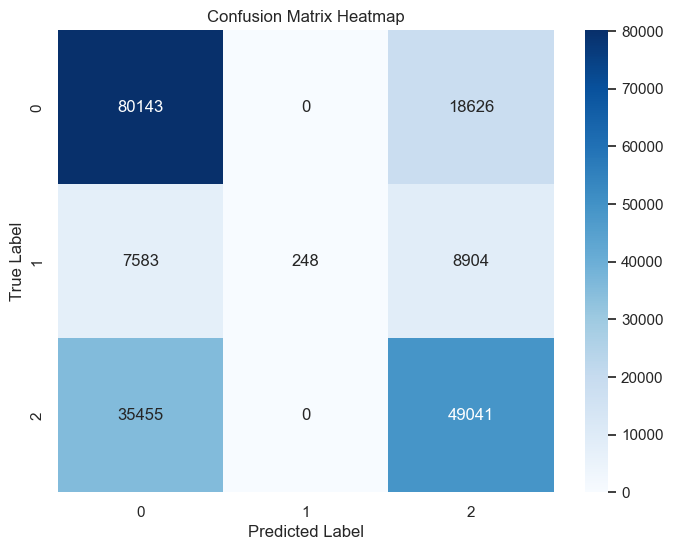

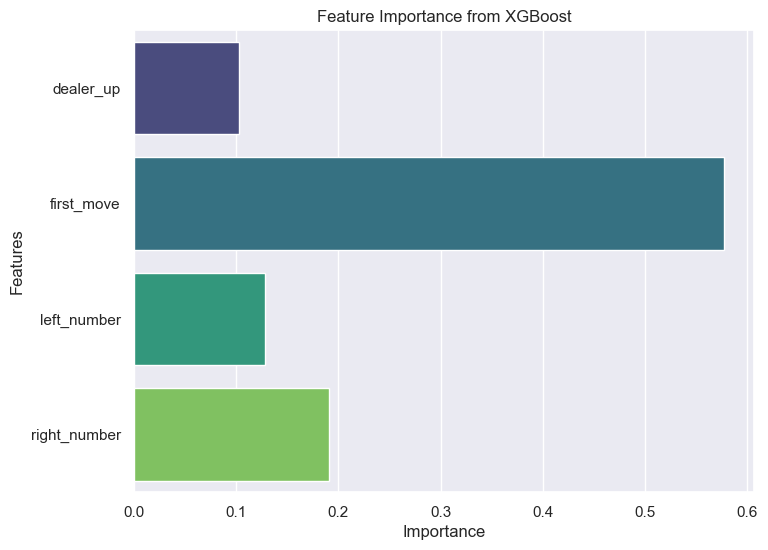

In [331]:
# Visualization 1: Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=xgb_model_2.classes_, yticklabels=xgb_model_2.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Visualization 2: Feature Importance
feature_importances_2 = xgb_model_2.feature_importances_

plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances_2, y=X_2.columns, hue=X_2.columns, palette="viridis")
plt.title("Feature Importance from XGBoost")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()